# Chemical Space Networks Based on Maximum Common Substructure

**V.F. Scalfani, V.D. Patel, and A.M. Fernandez** \
v. October 19, 2022

*w/ glucocorticoid_receptor_2034_2.csv dataset*

## 1. Import RDKit, Networkx, and other libraries

In [210]:
# RDKit stuff
from rdkit import Chem
from rdkit import rdBase
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdFMCS
from rdkit import DataStructs

# numpy
import numpy as np

# pandas
import pandas as pd

# networkx
import networkx as nx

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

In [211]:
# Print versions of libraries used
print('RDKit version: ',rdBase.rdkitVersion)
print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Networkx version',nx.__version__)
print('MatplotLib version:', mpl.__version__)

RDKit version:  2023.03.1
Numpy version: 1.24.3
Pandas version: 2.0.1
Networkx version 2.8.8
MatplotLib version: 3.7.1


# 2. Load Data

In [212]:
# load the subsets data
import pickle
with open('subsets_nucleophile.pickle', 'rb') as infile:
    subsets = pickle.load(infile)

In [213]:
list(subsets.values())[0:5]

[{'smi1': 'C/C(=C\\CCCCCl)C(=O)/C=C/C(C)C',
  'smi2': 'C/C(=C\\CCc1ccccc1)C(=O)/C=C/C(C)C',
  'mol1': <rdkit.Chem.rdchem.Mol at 0x7fc51165d210>,
  'mol2': <rdkit.Chem.rdchem.Mol at 0x7fc51165d300>,
  'tan_similarity': 0.489,
  'tan_mcs': 0.684},
 {'smi1': 'C/C(=C\\CCCCCl)C(=O)/C=C/C(C)C',
  'smi2': 'C/C=C(C)/C(=O)/C=C/C(C)(C)C',
  'mol1': <rdkit.Chem.rdchem.Mol at 0x7fc51165ecf0>,
  'mol2': <rdkit.Chem.rdchem.Mol at 0x7fc51165f150>,
  'tan_similarity': 0.68,
  'tan_mcs': 0.667},
 {'smi1': 'C/C(=C\\CCCCCl)C(=O)/C=C/C(C)C',
  'smi2': 'C/C=C(C)/C(=O)/C=C/C(C)C',
  'mol1': <rdkit.Chem.rdchem.Mol at 0x7fc51165cd10>,
  'mol2': <rdkit.Chem.rdchem.Mol at 0x7fc51165e750>,
  'tan_similarity': 0.719,
  'tan_mcs': 0.714},
 {'smi1': 'C/C(=C\\CCCCCl)C(=O)/C=C/C(C)C',
  'smi2': 'C/C=C(C)/C=C/CCO',
  'mol1': <rdkit.Chem.rdchem.Mol at 0x7fc51146a110>,
  'mol2': <rdkit.Chem.rdchem.Mol at 0x7fc5114cf010>,
  'tan_similarity': 0.152,
  'tan_mcs': 0.294},
 {'smi1': 'C/C(=C\\CCCCCl)C(=O)/C=C/C(C)C',
  'smi2'

In [214]:
# load the node data
with open('node_data_nucleophile.pickle', 'rb') as infile:
    node_data = pickle.load(infile)

In [215]:
list(node_data.keys())[0:5]

['C/C(=C\\CCCCCl)C(=O)/C=C/C(C)C',
 'C/C(=C\\CCc1ccccc1)C(=O)/C=C/C(C)C',
 'C/C=C(C)/C(=O)/C=C/C(C)(C)C',
 'C/C=C(C)/C(=O)/C=C/C(C)C',
 'C/C=C(C)/C=C/CCO']

In [216]:
list(node_data.values())[0:5]

[{'pKi': 88.0}, {'pKi': 86.0}, {'pKi': 94.0}, {'pKi': 90.0}, {'pKi': 93.0}]

# 3. Create CSN based on Maximum Common Substructure-based Similarity

In [217]:
# total number of possible edges
len(subsets)

1128

In [218]:
# We will try and match the number of edges for the MCS CSN to the tanimoto similarity CSN example
# See Zhang, B. et al. J Comput Aided Mol Des 2015, 29 (10), 937–950. https://doi.org/10.1007/s10822-015-9872-1.

# In our example: >= 0.68 tanimoto similarity, edges = 7739, edge_density = 0.095

# loop through and find a suitable similarity value for MCS that gets about 7700 edges
mcs_range = np.linspace(0,1,201) # get a range of numbers for 0 to 1, by 0.05
subsets_filtered_mcs = {}
for similarity_mcs in mcs_range:
    subsets_filtered_mcs = {key: value for key, value in subsets.items() if value['tan_mcs'] >= similarity_mcs}
    if 3000 < len(subsets_filtered_mcs) <= 3800:
        print(similarity_mcs)

In [219]:
subsets_filtered_mcs = {}
subsets_filtered_mcs = {key: value for key, value in subsets.items() if value['tan_mcs'] >= 0.62}
len(subsets_filtered_mcs) # equals number of edges

128

In [220]:
# Edge density (number of edges / number of total edges)
# Defined in: Zhang, B. et al.J Comput Aided Mol Des 2015, 29 (10), 937–950. 
# https://doi.org/10.1007/s10822-015-9872-1.

edge_density_mcs = round((len(subsets_filtered_mcs) / len(subsets)),3)
edge_density_mcs

0.113

In [221]:
# create a list of SMILES that will be nodes from the edges
smi1_filtered_mcs = []
smi2_filtered_mcs = []
for key,value in subsets_filtered_mcs.items():
    smi1_filtered_mcs.append(value['smi1'])
    smi2_filtered_mcs.append(value['smi2'])
    
# combine the 2 lists
smi12_filtered_mcs = smi1_filtered_mcs + smi2_filtered_mcs

# get unique
smi12_filtered_set = set(smi12_filtered_mcs)
len(smi12_filtered_set) # of nodes (smiles) in network

42

In [222]:
len(node_data) # original

48

In [223]:
smis = []
for key,value in node_data.items():
    smis.append(key)

In [224]:
# print list of nodes that are not in the filtered list
nodes_to_remove = set(smis) - smi12_filtered_set
nodes_to_remove

{'C=C(/C=C/C(C)(C)C)C(C)(C)C',
 'C=C(/C=C/c1ccccc1)O[Si](C)(C)C(C)(C)C',
 'C=C(C)/C=C/CCOCc1ccccc1',
 'C=C(O[Si](C)(C)C(C)(C)C)c1ccccc1',
 'C=CC(=C)CC/C=C(C)\\C',
 'C=CC[Si](C)(C)C'}

In [225]:
# finally, we can remove these from the node data as follows:
# this removes nodes from the graph with no edges
node_data_filtered_mcs = {node: node_data[node] for node in list(smi12_filtered_set)}
len(node_data_filtered_mcs)

42

## Plot MCS Similarity-based CSN as circle nodes

In [226]:
# Create a graph and add edges
G1 = nx.Graph()
for key, value in subsets_filtered_mcs.items():
    G1.add_edge(value['smi1'], value['smi2'], weight=value['tan_mcs'])

In [227]:
# The weights are stored in edge_data:
#for edge in G1.edges(data=True):
#    print(edge)

In [228]:
# Add attributes to nodes
for key,value in node_data_filtered_mcs.items():
    G1.add_node(key, pKi=value['pKi'])

In [229]:
# view the added node attributes as follows:
# for node in G1.nodes(data=True):
#     print(node[0],node[1]["ID"],node[1]["pKi"])

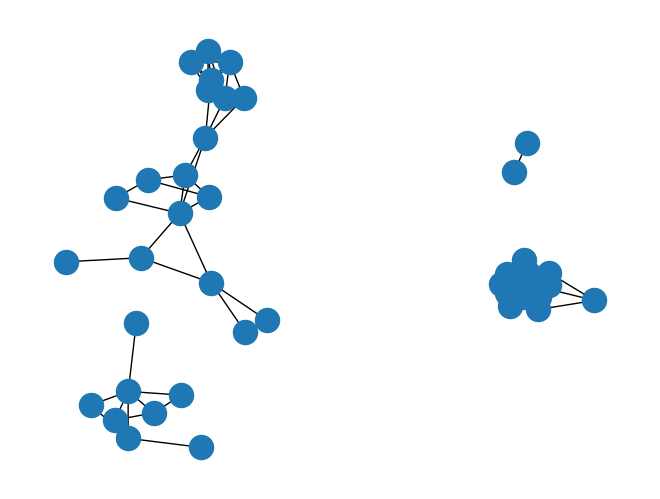

In [230]:
pos = nx.spring_layout(G1, k=0.3,seed=40) # added a seed for layout reproducibility, k is space between nodes
nx.draw(G1,pos)
plt.axis("off")
plt.show()

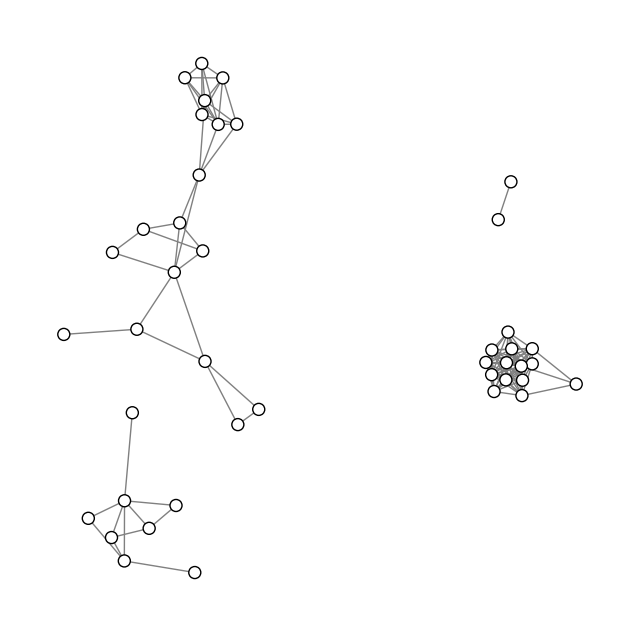

In [231]:
# Add color to nodes based on pKi value and adjust size
# list of colors: https://matplotlib.org/stable/gallery/color/named_colors.html

from matplotlib import colors

color_map = []
for node in G1.nodes(data=True):
    if 0<= node[1]["pKi"]*100 <= 30:
        color_map.append("darkred")
    elif 30 < node[1]["pKi"]*100  <= 50:
        color_map.append("red")
    elif 50 < node[1]["pKi"]*100  <= 70:
        color_map.append("orange")
    elif 70 < node[1]["pKi"]*100  <= 80:
        color_map.append("yellow")
    elif 80 < node[1]["pKi"]*100  <= 90:
        color_map.append("green")
    elif 90 < node[1]["pKi"]*100  <= 100:
        color_map.append("lightblue")
    else:
        color_map.append("white")

pos = nx.spring_layout(G1, k=0.3, seed=40) # added a seed for layout reproducibility
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw_networkx_nodes(G1, pos, node_size=75, node_color=color_map, edgecolors="black")
nx.draw_networkx_edges(G1, pos, edge_color="grey")
plt.axis("off")
plt.show()      

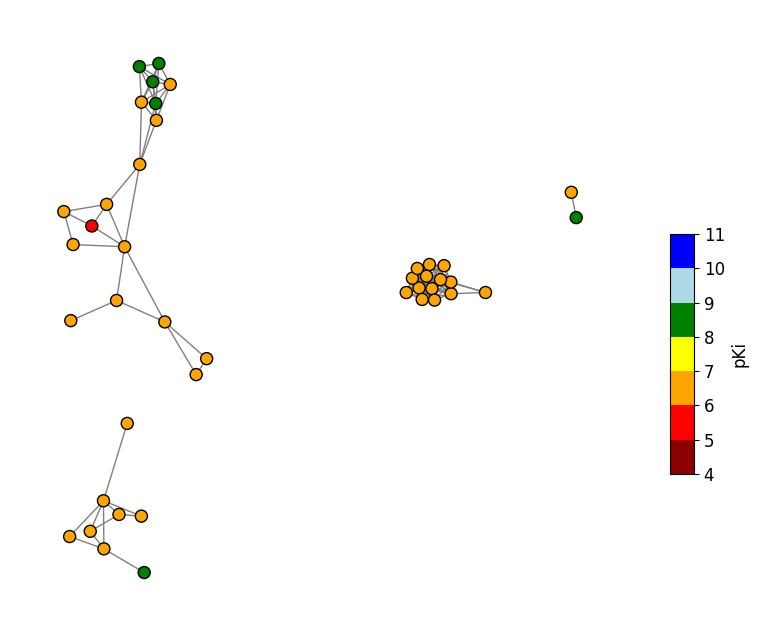

In [232]:
# Add legends

from matplotlib import colors

color_map = []
for node in G1.nodes(data=True):
    if 0 < node[1]["pKi"] <= 50:
        color_map.append("red")
    elif 50 < node[1]["pKi"] <= 95:
        color_map.append("orange")
    elif 95 < node[1]["pKi"] <= 100:
        color_map.append("green")
    else:
        color_map.append("white")

pos = nx.spring_layout(G1, k=0.2, seed=40) # added a seed for layout reproducibility
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw_networkx_nodes(G1, pos, node_size=75, node_color=color_map, edgecolors="black")
nx.draw_networkx_edges(G1, pos, edge_color="grey")
plt.axis("off")

# add legends
# https://matplotlib.org/stable/tutorials/colors/colorbar_only.html

ax2 = fig.add_axes([0.95, 0.3, 0.03, 0.3]) # distance left, distance up, width size, height size

cmap = (colors.ListedColormap(["darkred","red","orange",
                               "yellow","green","lightblue","blue"]))
bounds = [4, 5, 6, 7, 8, 9, 10, 11]
norm = colors.BoundaryNorm(bounds, cmap.N)
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=ax2,
    extend='neither',
    ticks=bounds,
    spacing='proportional',
    orientation='vertical',

)
cbar.ax.tick_params(labelsize=12)
ax2.set_ylabel('pKi', size=12)
plt.show()

In [233]:
# Get number of seperate connected components
nx.number_connected_components(G1)

4

In [234]:
# Save a list of the individual connected component graphs
connected_graphs1 = [G1.subgraph(c).copy() for c in nx.connected_components(G1)]

In [235]:
len(connected_graphs1)

4

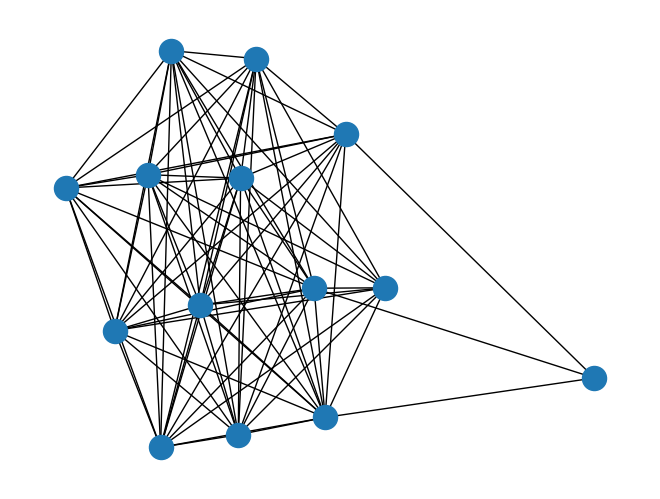

In [236]:
# Let's look one of the subgraphs
H1 = connected_graphs1[0]
pos = nx.spring_layout(H1, seed=30) # added a seed for layout reproducibility
nx.draw(H1,pos)
plt.axis("off")
plt.show()

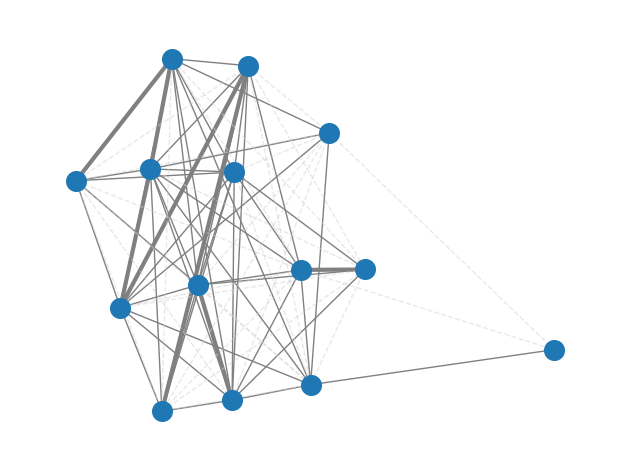

In [237]:
# Let's add in the weights, which would be similarity as line thickness
# Adapted from: https://networkx.org/documentation/stable/auto_examples/drawing/plot_weighted_graph.html?highlight=weighted_graph
thick = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] >= 0.9]
medium = [(u, v) for (u, v, d) in H1.edges(data=True) if 0.7 < d["weight"] < 0.9]
thin = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] <= 0.7]

pos = nx.spring_layout(H1, seed=30)
nx.draw_networkx_nodes(H1, pos, node_size=200)
nx.draw_networkx_edges(H1, pos, edgelist=thick, width=3, edge_color="grey")
nx.draw_networkx_edges(H1, pos, edgelist=medium, width=1, edge_color="grey")
nx.draw_networkx_edges(H1, pos, edgelist=thin, width=1, alpha=0.5, edge_color="lightgrey", style="dashed")
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

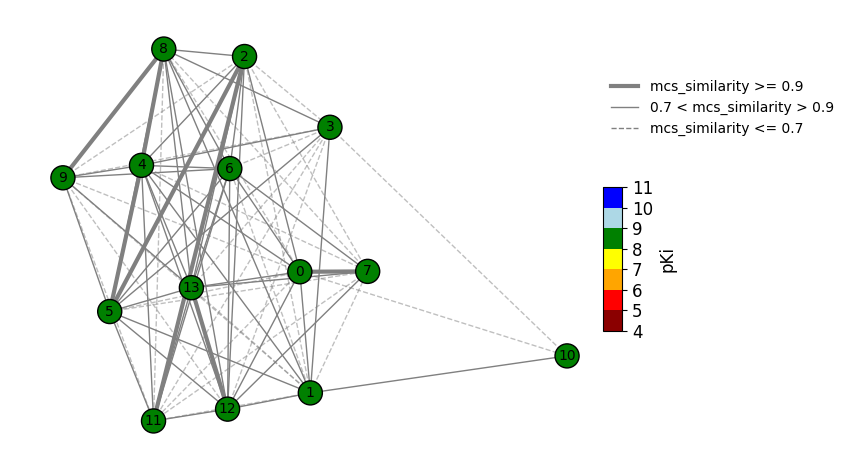

In [238]:
# Next add in the color for the nodes as before and number the nodes
fig, ax = plt.subplots()

# Line weights based on similarity value
thick = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] >= 0.9]
medium = [(u, v) for (u, v, d) in H1.edges(data=True) if 0.7 < d["weight"] < 0.9]
thin = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] <= 0.7]

# Add color based on pKi and node number labels
custom_labels = {}
color_map = []
label_number = 0
for node in H1.nodes(data=True):
    custom_labels[node[0]] = str(label_number)
    label_number+=1
    if 0 < node[1]["pKi"] <= 50:
        color_map.append("red")
    elif 50 < node[1]["pKi"] <= 70:
        color_map.append("orange")
    elif 70 < node[1]["pKi"] <= 100:
        color_map.append("green")
    else:
        color_map.append("white")

# plot with weights, node color, and labels.
pos = nx.spring_layout(H1, seed=30)
nx.draw_networkx_nodes(H1, pos, ax=ax, node_size=300, node_color=color_map, edgecolors="black")
nx.draw_networkx_labels(H1, pos, custom_labels, ax=ax, font_size=10, font_color="black")
nx.draw_networkx_edges(H1, pos, ax=ax, edgelist=thick, width=3, edge_color="grey")
nx.draw_networkx_edges(H1, pos, ax=ax, edgelist=medium, width=1, edge_color="grey")
nx.draw_networkx_edges(H1, pos, ax=ax, edgelist=thin, width=1, alpha=0.5, edge_color="grey", style="dashed")
ax = plt.gca()
plt.axis("off")
plt.tight_layout()


# add legends
# https://matplotlib.org/stable/tutorials/colors/colorbar_only.html

ax2 = fig.add_axes([0.95, 0.3, 0.03, 0.3]) # distance left, distance up, width size, height size

cmap = (colors.ListedColormap(["darkred","red","orange",
                               "yellow","green","lightblue","blue"]))
bounds = [4, 5, 6, 7, 8, 9, 10, 11]
norm = colors.BoundaryNorm(bounds, cmap.N)
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=ax2,
    extend='neither',
    ticks=bounds,
    spacing='proportional',
    orientation='vertical',

)
cbar.ax.tick_params(labelsize=12)
ax2.set_ylabel('pKi', size=12)

ax3 = fig.add_axes([1.3, 0.55, 0.03, 0.3]) # distance left, distance up, width size, height size
ax3.axis("off")
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="gray", lw=3),
                Line2D([0], [0], color="grey", lw=1),
                Line2D([0], [0], color="grey", lw=1, linestyle='dashed',)]

ax3.legend(custom_lines, ['mcs_similarity >= 0.9', '0.7 < mcs_similarity > 0.9', 'mcs_similarity <= 0.7'],
           loc='best', prop={'size': 10}, fancybox=True, framealpha=0)

plt.savefig('Figure-03_MCS_1_node_lines.png', bbox_inches='tight')
plt.show()

In [239]:
custom_labels

{'CC/C=C(C)/C(=O)/C=C/C1CCCCC1': '0',
 'CCCCC/C=C(C)/C(=O)/C=C/C(C)C': '1',
 'CC/C=C(C)/C(=O)/C=C/CCC': '2',
 'C/C(=C\\CCCCCl)C(=O)/C=C/C(C)C': '3',
 'CC/C=C(C)/C(=O)/C=C/C(C)C': '4',
 'CC/C=C(C)/C(=O)/C=C/C1CC1': '5',
 'CC/C=C(C)/C(=O)/C=C/C1CCC1': '6',
 'CC/C=C(C)/C(=O)/C=C/c1ccccc1Br': '7',
 'C/C=C(C)/C(=O)/C=C/C(C)C': '8',
 'C/C=C(C)/C(=O)/C=C/C(C)(C)C': '9',
 'C/C(=C\\CCc1ccccc1)C(=O)/C=C/C(C)C': '10',
 'CC/C=C(C)/C(=O)/C=C/CC(C)C': '11',
 'CC/C=C(C)/C(=O)/C=C/C1CCCC1': '12',
 'CC/C=C(C)/C(=O)/C=C/C(CC)CC': '13'}

In [240]:
# add the node data to a dataframe
columns = ("Smiles", "ID","pKi")
index = tuple(custom_labels.values())
table_data = []
#label_number = 0
for node in H1.nodes(data=True):
    Smiles = node[0]
    id_value = node[1]
    Ki = node[1]["pKi"]
    table_data.append([Smiles, id_value, Ki])
#    label_number += 1
df_H1 = pd.DataFrame(table_data, columns = columns, index=index)
df_H1

,Smiles,ID,pKi
0,CC/C=C(C)/C(=O)/C=C/C1CCCCC1,{'pKi': 92.0},92.0
1,CCCCC/C=C(C)/C(=O)/C=C/C(C)C,{'pKi': 88.0},88.0
2,CC/C=C(C)/C(=O)/C=C/CCC,{'pKi': 86.0},86.0
3,C/C(=C\CCCCCl)C(=O)/C=C/C(C)C,{'pKi': 88.0},88.0
4,CC/C=C(C)/C(=O)/C=C/C(C)C,{'pKi': 78.0},78.0
5,CC/C=C(C)/C(=O)/C=C/C1CC1,{'pKi': 84.0},84.0
6,CC/C=C(C)/C(=O)/C=C/C1CCC1,{'pKi': 92.0},92.0
7,CC/C=C(C)/C(=O)/C=C/c1ccccc1Br,{'pKi': 76.0},76.0
8,C/C=C(C)/C(=O)/C=C/C(C)C,{'pKi': 90.0},90.0
9,C/C=C(C)/C(=O)/C=C/C(C)(C)C,{'pKi': 94.0},94.0


## Plot MCS Similarity-based CSN with 2D Structure Depictions as Nodes

In [241]:
# png function to view molecules
import io
from PIL import Image
def show_png(data):
    bio = io.BytesIO(data)
    img = Image.open(bio)
    return img

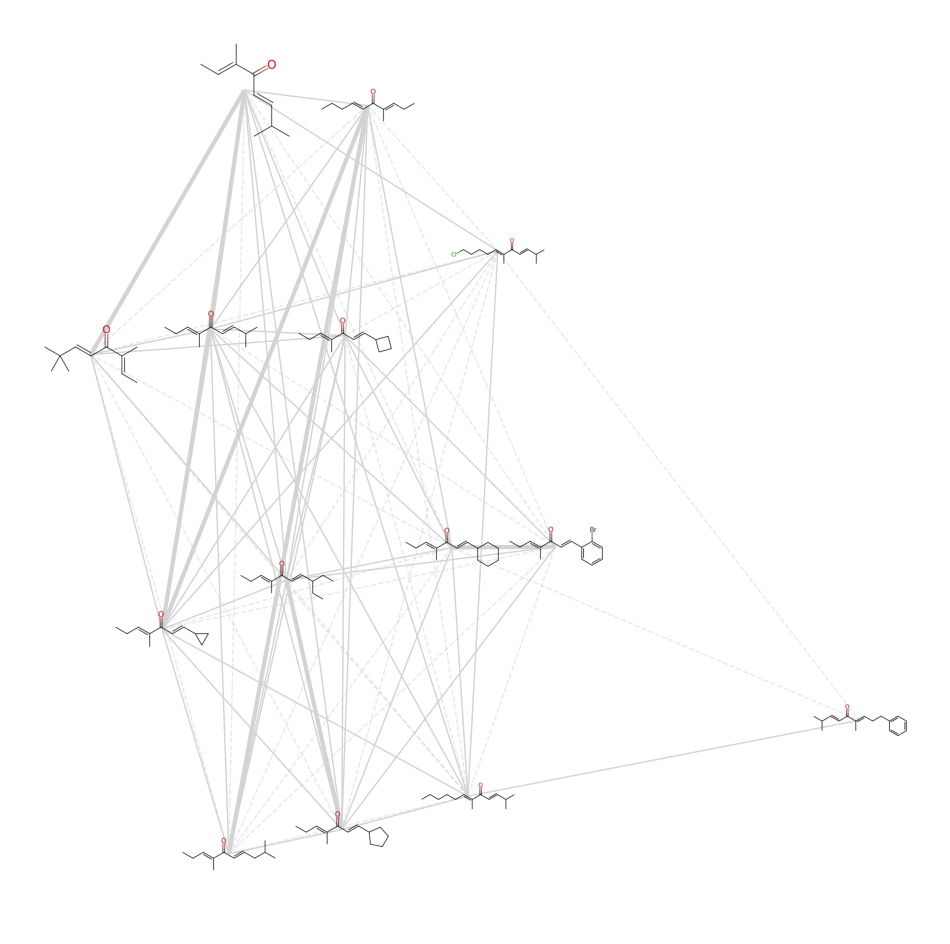

In [242]:
# now let's create a basic plot with the molecule images and line weights:
# Adapted from: https://networkx.org/documentation/stable/auto_examples/drawing/plot_custom_node_icons.html
# and https://networkx.org/documentation/stable/auto_examples/drawing/plot_weighted_graph.html?highlight=weighted_graph
thick = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] >= 0.9]
medium = [(u, v) for (u, v, d) in H1.edges(data=True) if 0.7 < d["weight"] < 0.9]
thin = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] <= 0.7]

pos = nx.spring_layout(H1, seed=30)
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=thick, width=3, edge_color="lightgrey")
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=medium, width=1, edge_color="lightgrey")
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=thin, width=1, alpha=0.5, edge_color="lightgrey", style="dashed")
ax.axis('off')

# Transform from data coordinates (scaled between xlim and ylim) to display coordinates
tr_figure = ax.transData.transform
# Transform from display to figure coordinates
tr_axes = fig.transFigure.inverted().transform

# Select the size of the image (relative to the X axis)
struct_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.045 # adjust this value to change size of structure drawings
struct_center = struct_size / 2.0

# Add the respective image to each node
for smi in H1.nodes:
    
    # draw molecule
    drawer = rdMolDraw2D.MolDraw2DCairo(300,300)
    drawer.drawOptions().clearBackground = False
    drawer.drawOptions().addStereoAnnotation = False
    drawer.DrawMolecule(Chem.MolFromSmiles(smi))
    drawer.FinishDrawing()
    mol = drawer.GetDrawingText()
         
    xf, yf = tr_figure(pos[smi])
    xa, ya = tr_axes((xf, yf))
    # get overlapped axes and plot structure
    a = plt.axes([xa - struct_center, ya - struct_center, struct_size, struct_size])
    a.imshow(show_png(mol))
    a.axis("off")
plt.savefig('Figure-04_MCS_1_structures_basic.png', bbox_inches='tight')  
plt.show()

In [243]:
# Next we can add color to the molecules with highlighting
# list of colors: https://matplotlib.org/stable/gallery/color/named_colors.html
# get some rgba values
from matplotlib import colors
print(colors.to_rgba('darkred'))
print(colors.to_rgba('red'))
print(colors.to_rgba('orange'))
print(colors.to_rgba('yellow'))
print(colors.to_rgba('green'))
print(colors.to_rgba('lightblue'))
print(colors.to_rgba('blue'))
print(colors.to_rgba('white'))

(0.5450980392156862, 0.0, 0.0, 1.0)
(1.0, 0.0, 0.0, 1.0)
(1.0, 0.6470588235294118, 0.0, 1.0)
(1.0, 1.0, 0.0, 1.0)
(0.0, 0.5019607843137255, 0.0, 1.0)
(0.6784313725490196, 0.8470588235294118, 0.9019607843137255, 1.0)
(0.0, 0.0, 1.0, 1.0)
(1.0, 1.0, 1.0, 1.0)


In [244]:
# define a function that highlights the molecule with the colors
# adjusted alpha values to make transparent
def highlight_mol(smi,label,color):
    
    mol = Chem.MolFromSmiles(smi)
    
    if color == 'darkred':
        rgba = (0.55, 0.0, 0.0, 0.3)       
    elif color == 'red':
        rgba = (1.0, 0.0, 0.0, 0.2)    
    elif color == 'orange':
        rgba = (1.0, 0.65, 0.0, 0.2)        
    elif color == 'yellow':
        rgba = (1.0, 1.0, 0.0, 0.4)        
    elif color == 'green':
        rgba = (0.0, 0.50, 0.0, 0.15)        
    elif color == 'lightblue':
        rgba = (0.68, 0.85, 0.90, 0.5)   
    elif color == 'blue':
        rgba = (0.0, 0.0, 1.0, 0.1)    
    else: # no color
        rgba = (1,1,1,1) 
             
    atoms = []
    for a in mol.GetAtoms():
        atoms.append(a.GetIdx())
    
    bonds = []
    for bond in mol.GetBonds():
        aid1 = atoms[bond.GetBeginAtomIdx()]
        aid2 = atoms[bond.GetEndAtomIdx()]
        bonds.append(mol.GetBondBetweenAtoms(aid1,aid2).GetIdx())

    drawer = rdMolDraw2D.MolDraw2DCairo(300,300)
    drawer.drawOptions().fillHighlights=True
    drawer.drawOptions().setHighlightColour((rgba))
    drawer.drawOptions().highlightBondWidthMultiplier=15
    drawer.drawOptions().legendFontSize=60
    drawer.drawOptions().clearBackground = False
    rdMolDraw2D.PrepareAndDrawMolecule(drawer, mol, legend=label,highlightAtoms=atoms, highlightBonds=bonds)
    
    mol_png = drawer.GetDrawingText()
    return mol_png

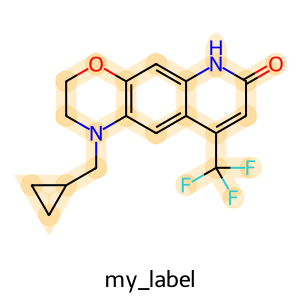

In [245]:
show_png(highlight_mol('O=c1cc(C(F)(F)F)c2cc3c(cc2[nH]1)OCCN3CC1CC1','my_label', 'orange'))

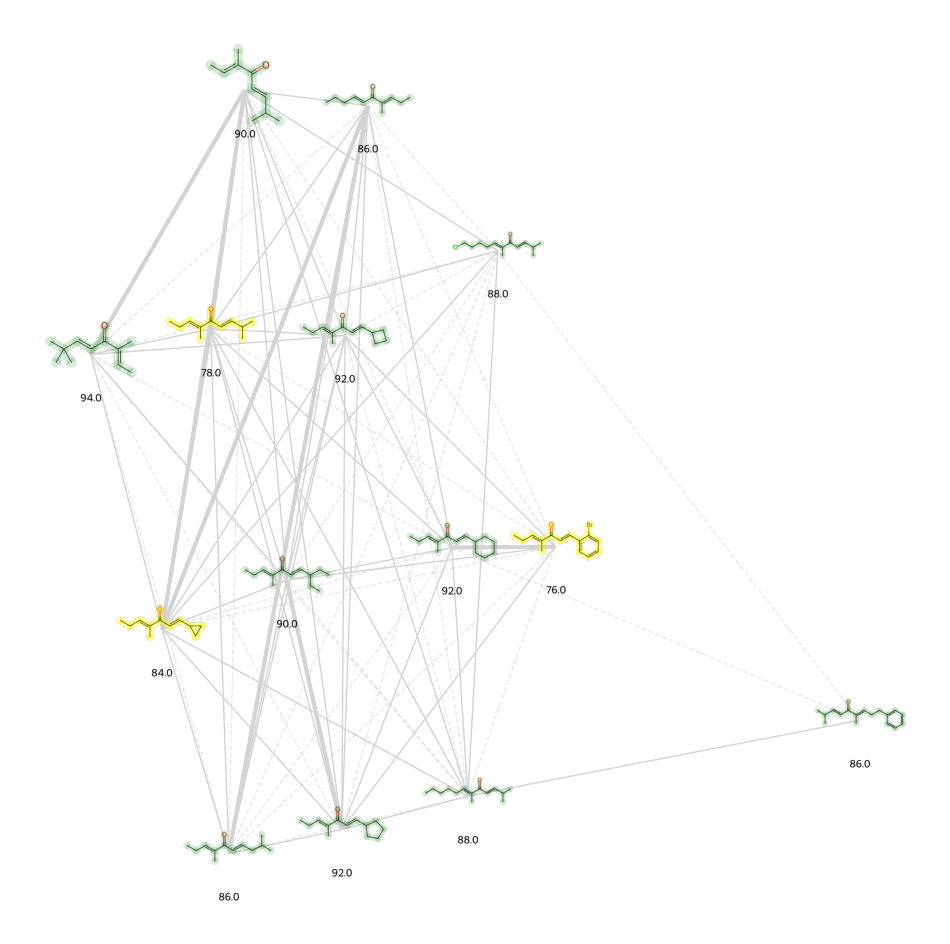

In [246]:
# Now add in color to molecules
H1 = connected_graphs1[0]

thick = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] >= 0.9]
medium = [(u, v) for (u, v, d) in H1.edges(data=True) if 0.7 < d["weight"] < 0.9]
thin = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] <= 0.7]

pos = nx.spring_layout(H1, seed=30)
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=thick, width=3, edge_color="lightgrey")
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=medium, width=1, edge_color="lightgrey")
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=thin, width=1, alpha=0.5, edge_color="lightgrey", style="dashed")
ax.axis('off')

# Transform from data coordinates (scaled between xlim and ylim) to display coordinates
tr_figure = ax.transData.transform
# Transform from display to figure coordinates
tr_axes = fig.transFigure.inverted().transform

# Select the size of the image (relative to the X axis)
struct_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.044
struct_center = struct_size / 2.0

# Add the respective image to each node

for smi,value in H1.nodes.items():


    if 0 < value["pKi"] <= 50:
        highlight_color = "darkred"

        
    elif 50 < value["pKi"] <= 70:
        highlight_color = "red"
    elif 70 < value["pKi"] <= 85:
        highlight_color = "yellow"
    elif 85 < value["pKi"] <= 100:
        highlight_color = "green"

    else:
        highlight_color = "white"

    xf, yf = tr_figure(pos[smi])
    xa, ya = tr_axes((xf, yf))
    # get overlapped axes and plot
    a = plt.axes([xa - struct_center, ya - struct_center, struct_size, struct_size])
    a.imshow(show_png(highlight_mol(smi,str(value["pKi"]), highlight_color)))
    a.axis("off")
         
plt.show()


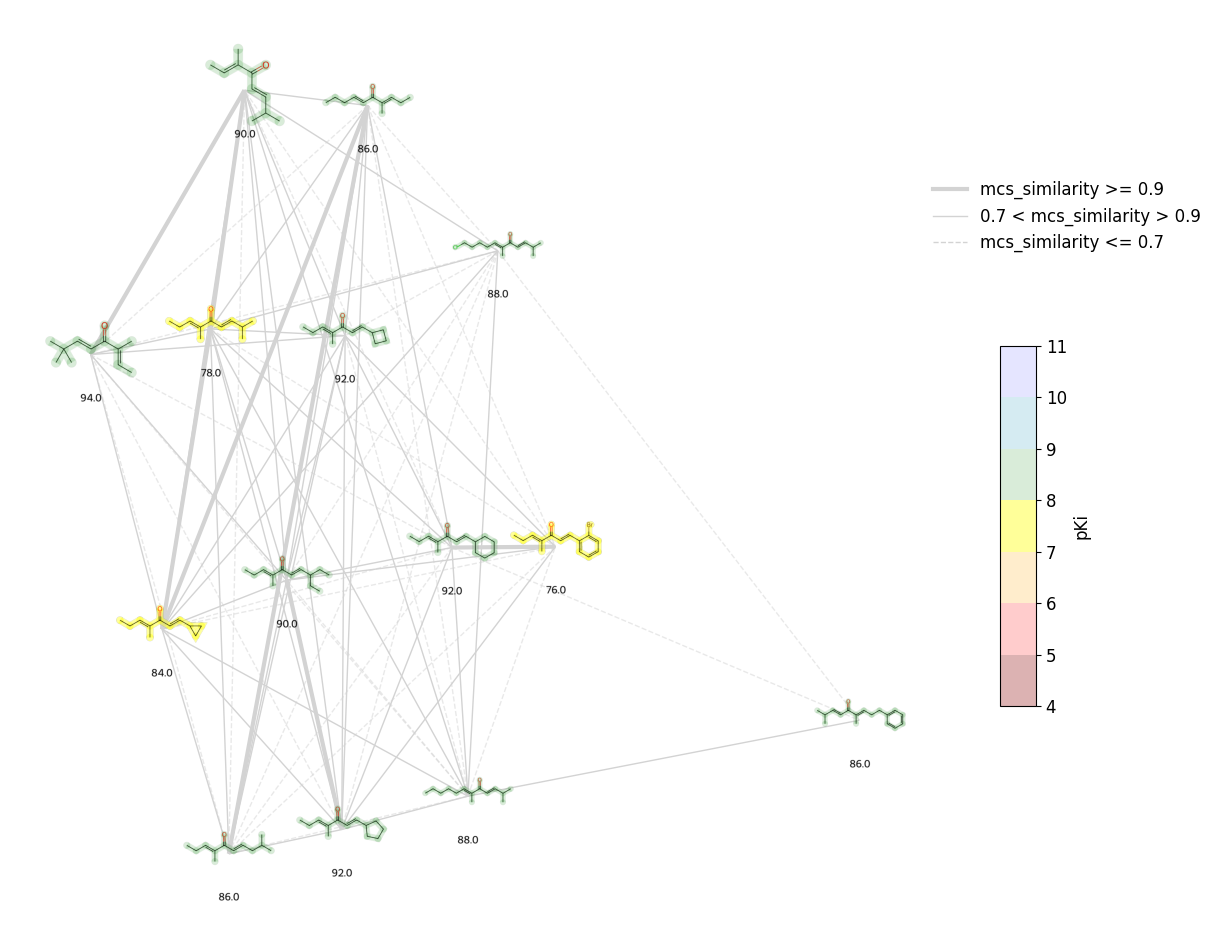

In [247]:
# Finally, add some legends
thick = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] >= 0.9]
medium = [(u, v) for (u, v, d) in H1.edges(data=True) if 0.7 < d["weight"] < 0.9]
thin = [(u, v) for (u, v, d) in H1.edges(data=True) if d["weight"] <= 0.7]

pos = nx.spring_layout(H1, seed=30)
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=thick, width=3, edge_color="lightgrey")
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=medium, width=1, edge_color="lightgrey")
nx.draw_networkx_edges(H1, pos=pos, ax=ax, edgelist=thin, width=1, alpha=0.5, edge_color="lightgrey", style="dashed")
ax.axis('off')

# Transform from data coordinates (scaled between xlim and ylim) to display coordinates
tr_figure = ax.transData.transform
# Transform from display to figure coordinates
tr_axes = fig.transFigure.inverted().transform

# Select the size of the image (relative to the X axis)
struct_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.044
struct_center = struct_size / 2.0

# Add the respective image to each node

for smi,value in H1.nodes.items():


    if 0 < value["pKi"] <= 50:
        highlight_color = "darkred"

        
    elif 50 < value["pKi"] <= 70:
        highlight_color = "red"
    elif 70 < value["pKi"] <= 85:
        highlight_color = "yellow"
    elif 85 < value["pKi"] <= 100:
        highlight_color = "green"

    else:
        highlight_color = "white"

    xf, yf = tr_figure(pos[smi])
    xa, ya = tr_axes((xf, yf))
    # get overlapped axes and plot
    a = plt.axes([xa - struct_center, ya - struct_center, struct_size, struct_size])
    a.imshow(show_png(highlight_mol(smi,str(value["pKi"]), highlight_color)))
    a.axis("off")

# add legends
# https://matplotlib.org/stable/tutorials/colors/colorbar_only.html
ax2 = fig.add_axes([0.95, 0.3, 0.03, 0.3]) # distance left, distance up, width size, height size

# define our modified colors for the color bar scale
darkred_bar = (0.55, 0.0, 0.0, 0.3)       
red_bar = (1.0, 0.0, 0.0, 0.2)    
orange_bar = (1.0, 0.65, 0.0, 0.2)        
yellow_bar = (1.0, 1.0, 0.0, 0.4)        
green_bar = (0.0, 0.50, 0.0, 0.15)        
lightblue_bar = (0.68, 0.85, 0.90, 0.5)   
blue_bar = (0.0, 0.0, 1.0, 0.1)    

cmap = (colors.ListedColormap([darkred_bar,red_bar,orange_bar,
                               yellow_bar,green_bar,lightblue_bar,blue_bar]))
bounds = [4, 5, 6, 7, 8, 9, 10, 11]
norm = colors.BoundaryNorm(bounds, cmap.N)
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=ax2,
    extend='neither',
    ticks=bounds,
    spacing='proportional',
    orientation='vertical',

)
cbar.ax.tick_params(labelsize=12)
ax2.set_ylabel('pKi', size=12)

ax3 = fig.add_axes([1.1, 0.45, 0.03, 0.3]) # distance left, distance up, width size, height size
ax3.axis("off")
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="lightgray", lw=3),
                Line2D([0], [0], color="lightgrey", lw=1),
                Line2D([0], [0], color="lightgrey", lw=1, linestyle='dashed',)]

ax3.legend(custom_lines, ['mcs_similarity >= 0.9', '0.7 < mcs_similarity > 0.9', 'mcs_similarity <= 0.7'],
           loc='best', prop={'size': 12}, fancybox=True, framealpha=0)
plt.savefig('Figure-05_MCS_1_structures_advanced.png',  bbox_inches='tight')
plt.show()

In [248]:
connected_graphs1

In [249]:
H2 = connected_graphs1[2]


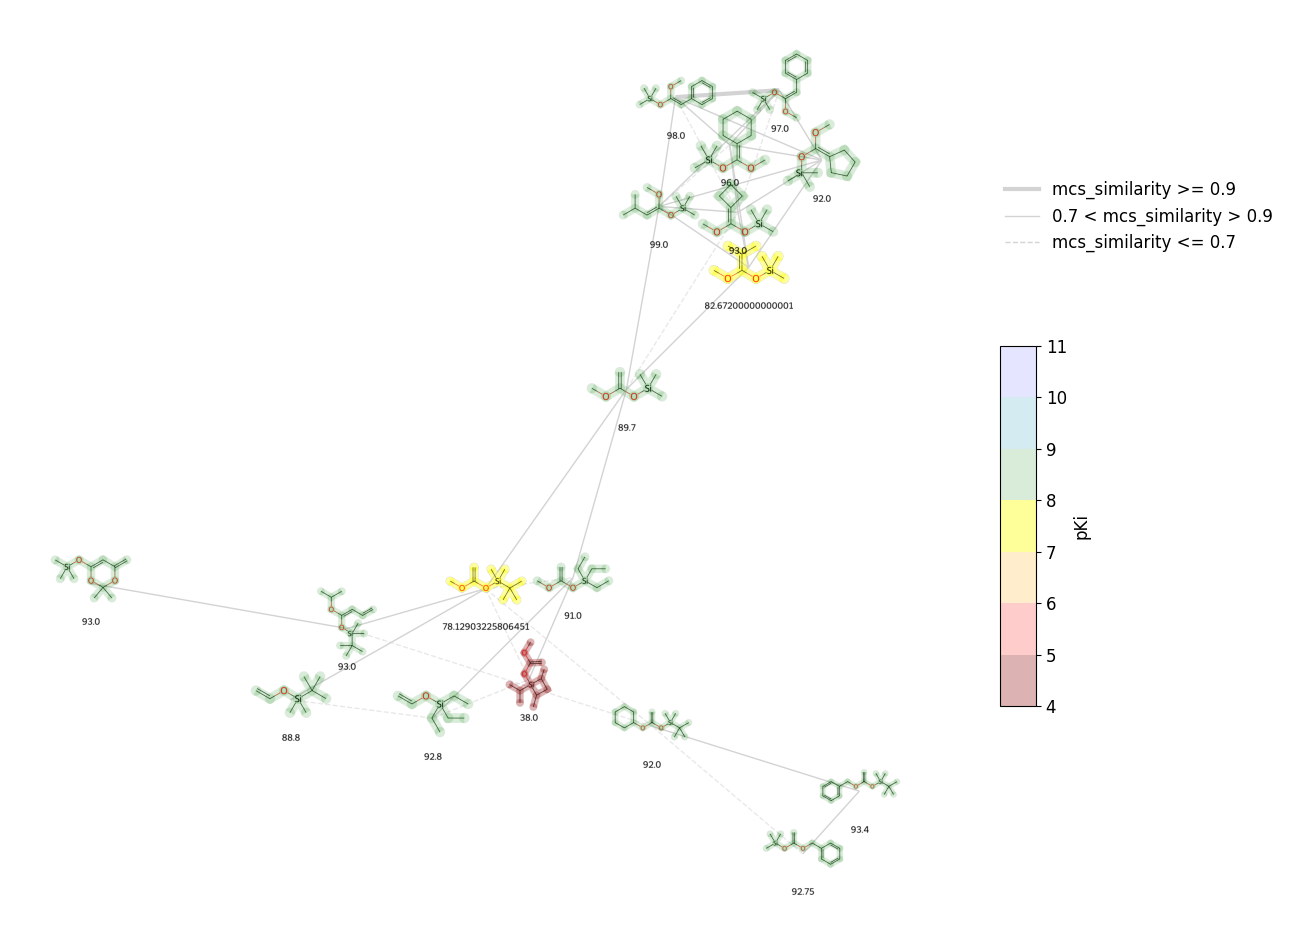

In [250]:
# Let's look at one more, with a different connected graph

thick = [(u, v) for (u, v, d) in H2.edges(data=True) if d["weight"] >= 0.9]
medium = [(u, v) for (u, v, d) in H2.edges(data=True) if 0.7 < d["weight"] < 0.9]
thin = [(u, v) for (u, v, d) in H2.edges(data=True) if d["weight"] <= 0.7]

pos = nx.spring_layout(H2, seed=42)
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_edges(H2, pos=pos, ax=ax, edgelist=thick, width=3, edge_color="lightgrey")
nx.draw_networkx_edges(H2, pos=pos, ax=ax, edgelist=medium, width=1, edge_color="lightgrey")
nx.draw_networkx_edges(H2, pos=pos, ax=ax, edgelist=thin, width=1, alpha=0.5, edge_color="lightgrey", style="dashed")
ax.axis('off')

# Transform from data coordinates (scaled between xlim and ylim) to display coordinates
tr_figure = ax.transData.transform
# Transform from display to figure coordinates
tr_axes = fig.transFigure.inverted().transform

# Select the size of the image (relative to the X axis)
struct_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
struct_center = struct_size / 2.0

# Add the respective image to each node

for smi,value in H2.nodes.items():


    if 0 < value["pKi"] <= 50:
        highlight_color = "darkred"

        
    elif 50 < value["pKi"] <= 70:
        highlight_color = "red"
    elif 70 < value["pKi"] <= 85:
        highlight_color = "yellow"
    elif 85 < value["pKi"] <= 100:
        highlight_color = "green"

    else:
        highlight_color = "white"

    xf, yf = tr_figure(pos[smi])
    xa, ya = tr_axes((xf, yf))
    # get overlapped axes and plot
    a = plt.axes([xa - struct_center, ya - struct_center, struct_size, struct_size])
    a.imshow(show_png(highlight_mol(smi,str(value["pKi"]), highlight_color)))
    a.axis("off")

# add legends

ax2 = fig.add_axes([0.95, 0.3, 0.03, 0.3]) # distance left, distance up, width size, height size
# https://matplotlib.org/stable/tutorials/colors/colorbar_only.html

# define our modified colors for the color bar scale
darkred_bar = (0.55, 0.0, 0.0, 0.3)       
red_bar = (1.0, 0.0, 0.0, 0.2)    
orange_bar = (1.0, 0.65, 0.0, 0.2)        
yellow_bar = (1.0, 1.0, 0.0, 0.4)        
green_bar = (0.0, 0.50, 0.0, 0.15)        
lightblue_bar = (0.68, 0.85, 0.90, 0.5)   
blue_bar = (0.0, 0.0, 1.0, 0.1)    

cmap = (colors.ListedColormap([darkred_bar,red_bar,orange_bar,yellow_bar,
                               green_bar,lightblue_bar,blue_bar]))
bounds = [4, 5, 6, 7, 8, 9, 10, 11]
norm = colors.BoundaryNorm(bounds, cmap.N)
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=ax2,
    extend='neither',
    ticks=bounds,
    spacing='proportional',
    orientation='vertical',

)
cbar.ax.tick_params(labelsize=12)
ax2.set_ylabel('pKi', size=12)

ax3 = fig.add_axes([1.16, 0.45, 0.03, 0.3]) # distance left, distance up, width size, height size
ax3.axis("off")
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="lightgray", lw=3),
                Line2D([0], [0], color="lightgrey", lw=1),
                Line2D([0], [0], color="lightgrey", lw=1, linestyle='dashed',)]

ax3.legend(custom_lines, ['mcs_similarity >= 0.9', '0.7 < mcs_similarity > 0.9', 'mcs_similarity <= 0.7'],
           loc='best', prop={'size': 12}, fancybox=True, framealpha=0)
plt.show()

# 4. Compute Some Network Properties

## Clustering Coefficient

In [251]:
node_coefficients = nx.clustering(G1, weight="weight")

# Get mean 
coefficients = []
for key,value in node_coefficients.items():
    coefficients.append(value)
    
avg_clustering_coefficient = np.mean(coefficients)
round(avg_clustering_coefficient,3)

0.493

In [252]:
# This also works:
round(nx.average_clustering(G1,weight="weight"),3)

0.493

## Degree Assortativity

In [253]:
round(nx.degree_assortativity_coefficient(G1,weight="weight"),3)

0.85

## Communities

In [254]:
# using the greedy_modularity_communities as an example
# There are many others, see the NetworkX docs

from networkx.algorithms.community import greedy_modularity_communities
communities = greedy_modularity_communities(G1, weight="weight") # added in similarity threshold as a weight

In [255]:
len(communities)

5

In [256]:
# create a list of colors from a matplotlib colormap
import matplotlib
cmap = matplotlib.cm.get_cmap('tab20')

color_intervals = np.linspace(0,1,len(communities)) # for 13 colors
colors_tab = []
for value in color_intervals:
    colors_tab.append(cmap(value))

/tmp/ipykernel_2102490/2302925821.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('tab20')


In [257]:
# add color to nodes by community group
community_color_map = []
for node in G1.nodes:
     for idx,community in enumerate(communities):
        if node in community:
            #print(node,idx)
            community_color_map.append(colors_tab[idx])

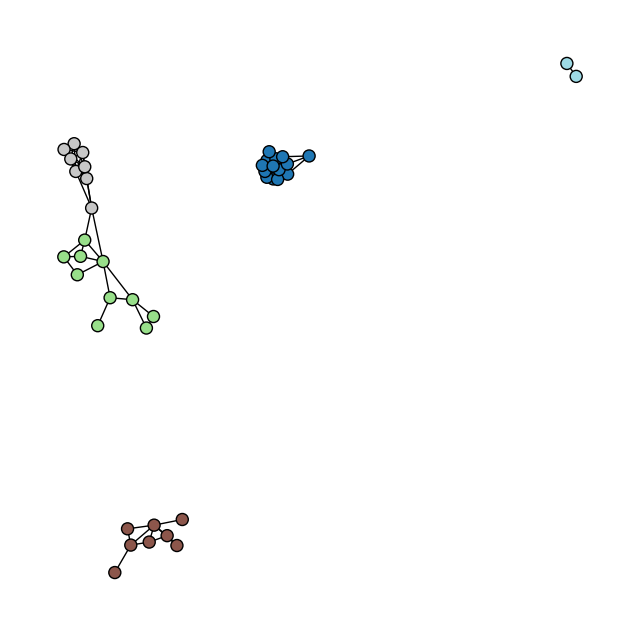

In [258]:
# plot nodes with color as community
pos = nx.spring_layout(G1, k=0.1, seed=40) # added a seed for layout reproducibility
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(G1,pos, node_color=community_color_map, edgecolors="black", node_size=75)
plt.axis("off")
plt.savefig("Figure-06--mcs_communities.png", bbox_inches='tight')
plt.show()  # how cool is that!

## Modularity

In [259]:
import networkx.algorithms.community as nx_comm
round(nx_comm.modularity(G1,communities),3)

0.557

In [260]:
len(G1.edges(["N[C@H]1Cc2ccccc2[C@@H]1NC(=S)Nc1cc(C(F)(F)F)cc(C(F)(F)F)c1"]))


0

In [261]:
G1.degree("N[C@H]1Cc2ccccc2[C@@H]1NC(=S)Nc1cc(C(F)(F)F)cc(C(F)(F)F)c1")

DegreeView({})

In [262]:
communities[0]

frozenset({'C/C(=C\\CCCCCl)C(=O)/C=C/C(C)C',
           'C/C(=C\\CCc1ccccc1)C(=O)/C=C/C(C)C',
           'C/C=C(C)/C(=O)/C=C/C(C)(C)C',
           'C/C=C(C)/C(=O)/C=C/C(C)C',
           'CC/C=C(C)/C(=O)/C=C/C(C)C',
           'CC/C=C(C)/C(=O)/C=C/C(CC)CC',
           'CC/C=C(C)/C(=O)/C=C/C1CC1',
           'CC/C=C(C)/C(=O)/C=C/C1CCC1',
           'CC/C=C(C)/C(=O)/C=C/C1CCCC1',
           'CC/C=C(C)/C(=O)/C=C/C1CCCCC1',
           'CC/C=C(C)/C(=O)/C=C/CC(C)C',
           'CC/C=C(C)/C(=O)/C=C/CCC',
           'CC/C=C(C)/C(=O)/C=C/c1ccccc1Br',
           'CCCCC/C=C(C)/C(=O)/C=C/C(C)C'})

[87.28571428571429, 87.9, 88.90283512544804, 96.75]
[14, 8, 18, 2]
[94.0, 97.0, 99.0, 99.0]


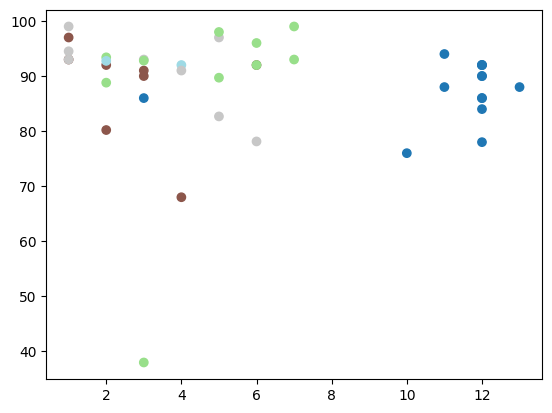

In [263]:
mean_ee = []
size = []
all_values_percom=[]
all_values = []
max_ee = []
edges = []
for i in range(len(connected_graphs1)):
    sub_values = []
    for smi,value in connected_graphs1[i].nodes.items():
        sub_values.append(value["pKi"])
        edges.append(len(G1.edges([smi])))
        all_values.append(value["pKi"])
    mean_ee.append(np.mean(sub_values))
    max_ee.append(np.max(sub_values))
    size.append(len(sub_values))
    all_values_percom.append(sub_values)
print(mean_ee)
print(size)
print(max_ee)
#plt.hist(edges)
plt.scatter(edges, all_values, color=community_color_map)

(array([10.,  6.,  3.,  4.,  4.,  2.,  0.,  1.,  2., 10.]),
 array([ 1. ,  2.2,  3.4,  4.6,  5.8,  7. ,  8.2,  9.4, 10.6, 11.8, 13. ]),
 <BarContainer object of 10 artists>)

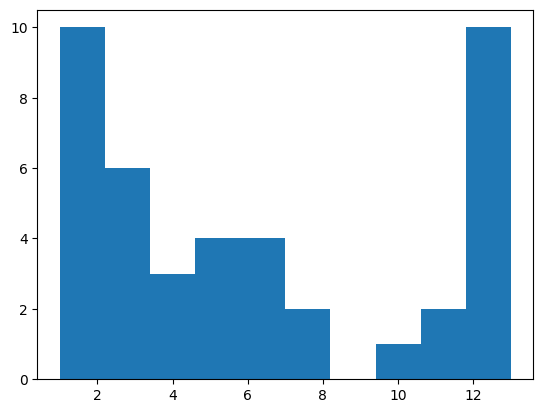

In [264]:
plt.hist( edges)

[87.28571428571429]
[14]
[94.0]
[11.142857142857142]
[0.7959183673469388]
[87.28571428571429]


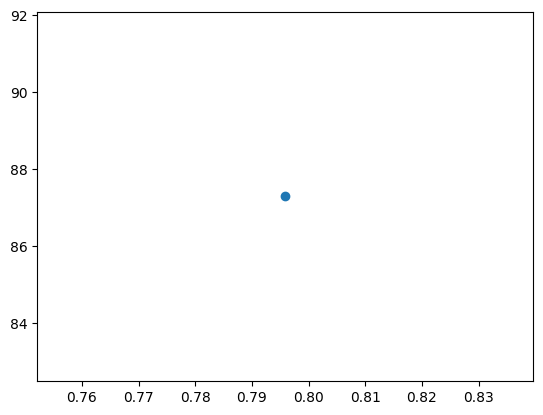

In [265]:
mean_ee = []
size = []
all_values=[]
max_ee = []
edg=[]
connect_ratio=[]
com_edges=[]
for comuinty in communities:
    sub_values = []
    edges=[]
    if len(comuinty)>10:
        for value in comuinty:
            sub_values.append(node_data[value]["pKi"])
            edg.append(G1.degree(value))

        com_edges.append(np.mean(edg))
        mean_ee.append(np.mean(sub_values))
        max_ee.append(np.max(sub_values))
        size.append(len(sub_values))
        all_values.append(sub_values)
        connect_ratio.append(np.mean(edg)/len(sub_values))
print(mean_ee)
print(size)
print(max_ee)
print(com_edges)
print(connect_ratio)
print(mean_ee)
plt.scatter(connect_ratio,mean_ee)

In [266]:
#rc=nx.rich_club_coefficient(G1, normalized=True,Q=200)
#Very strong "Rich-club" effect

Calculating best minimal value for power law fit
Power-law fit results:
Alpha (exponent) = 2.03
D (Kolmogorov-Smirnov test) = 0.17
0.5450869010668697
The exponent of the power-law distribution is 0.33732894136953573
 the KS test statistic is 0.18140765496353606
 the p-value is 0.11092956908019747
The exponent of the power-law distribution is 0.9565504697435389
 the KS test statistic is 0.0493616718408027
 the p-value is 0.9998166104505533


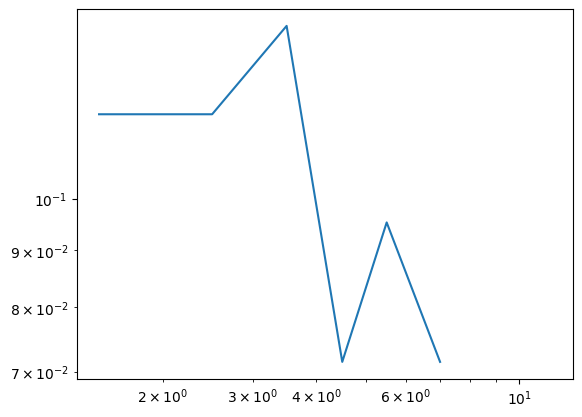

In [267]:
import powerlaw
from scipy import stats
degrees = [d for n, d in G1.degree()]


fit = powerlaw.Fit(degrees , discrete = True)


print("Power-law fit results:")
print("Alpha (exponent) = {:.2f}".format(fit.alpha))
print("D (Kolmogorov-Smirnov test) = {:.2f}".format(fit.D))
#print("p-value = {:.2f}".format(fit.power_law.likelihoods('truncated', fit)))
powerlaw.plot_pdf(degrees)
from scipy.stats import distributions
n1=len(degrees)
n2=len(degrees)
en = np.sqrt(n1 * n2 / float(n1 + n2))
prob = distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * fit.D) 
print(prob)


counts=degrees
fit_alpha, fit_loc, fit_scale = stats.powerlaw.fit(counts, loc=0)
D, p = stats.kstest(counts, 'powerlaw', args=(fit_alpha, fit_loc, fit_scale))
exponent = stats.powerlaw.fit(counts)[0]
print(f'The exponent of the power-law distribution is {exponent}')
print(f" the KS test statistic is {D}")  # Kolmogorov-Smirnov test statistic
print(f" the p-value is {p}")  # p-value of the test
counts = np.nonzero(counts)[0]
fit_alpha, fit_loc, fit_scale = stats.powerlaw.fit(counts, loc=0)
D, p = stats.kstest(counts, 'powerlaw', args=(fit_alpha, fit_loc, fit_scale))
exponent = stats.powerlaw.fit(counts)[0]
print(f'The exponent of the power-law distribution is {exponent}')
print(f" the KS test statistic is {D}")  # Kolmogorov-Smirnov test statistic
print(f" the p-value is {p}")  # p-value of the test
#Data doesn't come from powerlaw distribution if we look at all elements and fits into powerlaw if only at non zero elements

In [268]:

nx.smallworld.omega(connected_graphs1[2])

-0.2272727272727273

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([86.78571429, 86.88571429, 86.98571429, 87.08571429, 87.18571429,
        87.28571429, 87.38571429, 87.48571429, 87.58571429, 87.68571429,
        87.78571429]),
 <BarContainer object of 10 artists>)

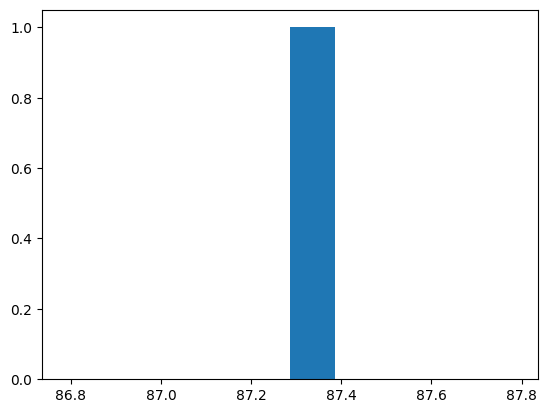

In [269]:
plt.hist(mean_ee)

In [270]:
degree_centrality = nx.degree_centrality(G1)
hubs = [node for node, centrality in degree_centrality.items() if centrality >= 0.35]
for hub in hubs:
    print(hub, node_data[hub]["Ki"])

In [271]:
betweenness_centrality = nx.betweenness_centrality(G1)
hubs = [node for node, centrality in betweenness_centrality.items() if centrality >= 0.15]
for hub in hubs:
    print(hub, node_data[hub]["pKi"], G1.degree([hub][0]))

In [272]:
eigen_centrality = nx.eigenvector_centrality(G1)
hubs = [node for node, centrality in eigen_centrality.items() if centrality >= 0.1]
for hub in hubs:
    print(hub, node_data[hub]["pKi"])

C/C(=C\CCCCCl)C(=O)/C=C/C(C)C 88.0
C/C=C(C)/C(=O)/C=C/C(C)(C)C 94.0
C/C=C(C)/C(=O)/C=C/C(C)C 90.0
CC/C=C(C)/C(=O)/C=C/C(C)C 78.0
CC/C=C(C)/C(=O)/C=C/C(CC)CC 90.0
CC/C=C(C)/C(=O)/C=C/C1CC1 84.0
CC/C=C(C)/C(=O)/C=C/C1CCC1 92.0
CC/C=C(C)/C(=O)/C=C/C1CCCC1 92.0
CC/C=C(C)/C(=O)/C=C/CC(C)C 86.0
CC/C=C(C)/C(=O)/C=C/CCC 86.0
CCCCC/C=C(C)/C(=O)/C=C/C(C)C 88.0
CC/C=C(C)/C(=O)/C=C/C1CCCCC1 92.0
CC/C=C(C)/C(=O)/C=C/c1ccccc1Br 76.0


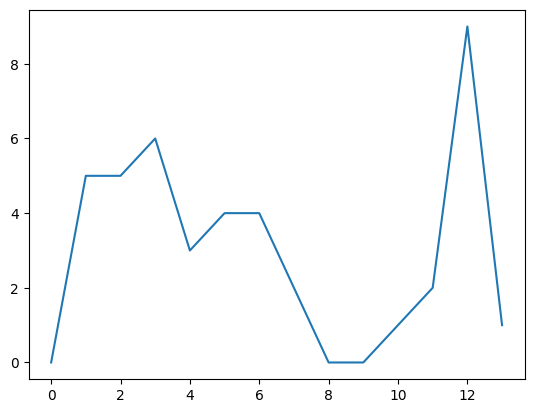

In [273]:
plt.plot(nx.degree_histogram(G1))

(array([1., 0., 0., 0., 0., 0., 1., 0., 0., 1.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

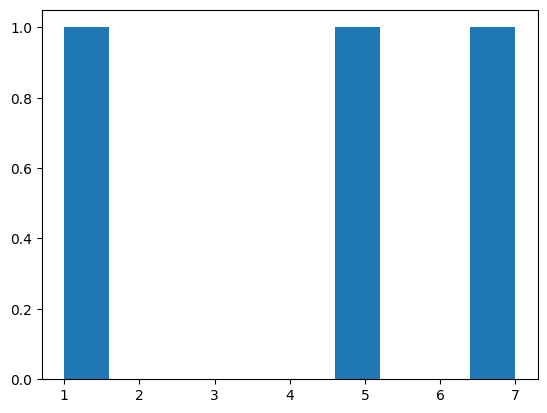

In [274]:
slected_data =  dict((n,d["pKi"]) for n,d in G1.nodes().items() if d["pKi"]>=98)
degrees = []
H = nx.induced_subgraph(G1, slected_data)
betweenes= []

#plt.plot(nx.degree_histogram(H))
for data in slected_data:
    degrees.append(G1.degree(data))
    #degrees.append(G1.betweenness_centrality(data))
    betweenes.append(betweenness_centrality[data])
degrees
plt.hist(degrees)



#plt.hist(edges)


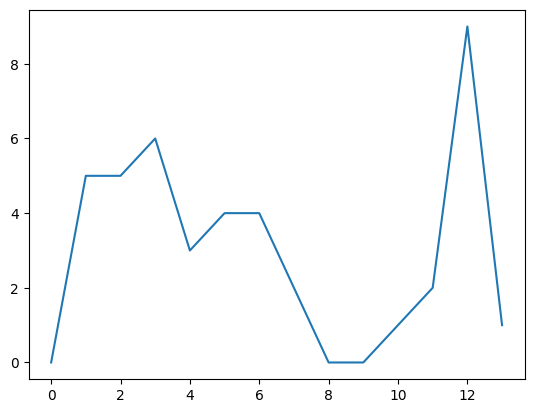

In [275]:
plt.plot(nx.degree_histogram(G1))

(array([2., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.        , 0.00229675, 0.0045935 , 0.00689024, 0.00918699,
        0.01148374, 0.01378049, 0.01607724, 0.01837398, 0.02067073,
        0.02296748]),
 <BarContainer object of 10 artists>)

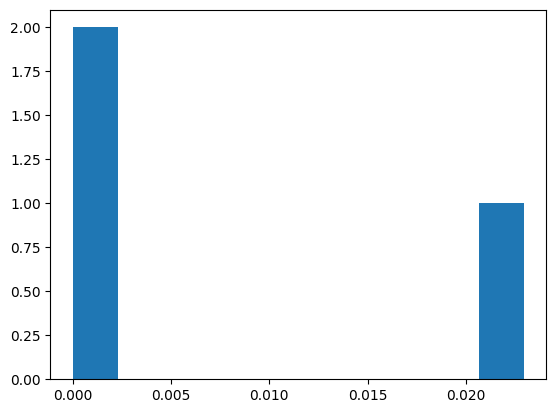

In [276]:
plt.hist(betweenes)


(array([33.,  3.,  3.,  0.,  1.,  0.,  0.,  0.,  0.,  2.]),
 array([0.        , 0.00890244, 0.01780488, 0.02670732, 0.03560976,
        0.0445122 , 0.05341463, 0.06231707, 0.07121951, 0.08012195,
        0.08902439]),
 <BarContainer object of 10 artists>)

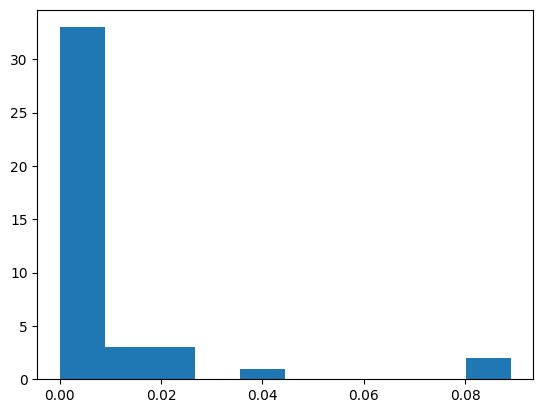

In [277]:
#plt.hist(betweenness_centrality.items())
betweenness_all = []
for node in G1.nodes().items():
    betweenness_all.append(betweenness_centrality[node[0]])
plt.hist(betweenness_all)

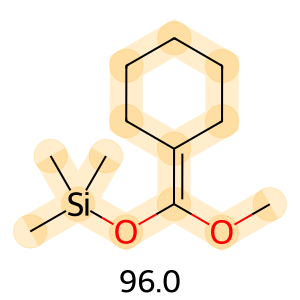

In [278]:
for edge in G1.edges().items():
    if edge[1]['weight'] >0.9:
        if abs(G1.nodes[edge[0][0]]["pKi"] - G1.nodes[edge[0][1]]["pKi"])>50:
            
            print(G1.nodes[edge[0][0]],G1.nodes[edge[0][1]])
            #print(edge[1]['weight'])
            print(G1.degree(edge[0][0]), G1.degree(edge[0][1]))
            #print(betweenness_centrality[edge[0][0]], betweenness_centrality[edge[0][1]])
show_png(highlight_mol(edge[0][0],str(G1.nodes[edge[0][0]]["pKi"]), 'orange'))
show_png(highlight_mol(edge[0][1],str(G1.nodes[edge[0][1]]["pKi"]), 'orange'))
#subsets_filtered_mcs = {key: value for key, value in G1.items() if value['tan_mcs'] >= 0.6}
#weight=value['tan_mcs']
